In [19]:
%load_ext autoreload
%autoreload 2
#plt.rcParams['figure.figsize'] = (16,8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [2]:
import pandas as pd
from purchase_prediction.import_data import import_transaction_club, import_transaction_ecom, import_sfid_email_ecom

In [3]:
# Import Club Customers
df_club = import_transaction_club(country='DE', start_observation_period='01012018', end_observation_period='01012020')
# Import ECom NonClub Customers
df_etmp = import_transaction_ecom(country='DE', start_observation_period='01012018', end_observation_period='01012020')
# Import keys linking mails and SFID
df_keys = import_sfid_email_ecom('Export_ClientInfo20200131.csv')
# Select these customers that have a valid email from ECom NonClub
df_ecom = df_etmp.merge(df_keys, on= 'Email', how='inner')
print(str(df_etmp.shape[0] - df_ecom.shape[0])+' lost ECom non Club customers based on Email merge')

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3242: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


514212 lost ECom non Club customers based on Email merge


## Munge data

In [6]:
from purchase_prediction.munging_pipeline import (start_pipeline, 
                                                  select_valid_cards, 
                                                  lower_cols, 
                                                  def_types, 
                                                  down_sample,
                                                  correct_timestamps, 
                                                  correct_for_retourned,
                                                  drop_retours,
                                                  assign_customer_type
                                                 )

from purchase_prediction.munging_pipeline_ecom import (rename_cols_ecom,
                                                       correct_timestamps_ecom,
                                                       def_types_ecom,
                                                       drop_cols
                                                       )

In [8]:
df_club_clean = (df_club
.pipe(start_pipeline)
.pipe(select_valid_cards)
.pipe(lower_cols)            
.pipe(correct_timestamps)
.pipe(def_types)
#.pipe(down_sample, threshold=50000)
#.pipe(correct_for_retourned) # This steps is very long (should be optimized). Only use if monetary value required.
.pipe(drop_retours)   
.pipe(assign_customer_type,label='club')
)

print('')
print('There are ' + str(df_club_clean.groupby(by='customer_salesforce_id').count().shape[0]) + ' customers.')

f/ select_valid_cards cleaned: 3568337 (i.e., 22.51% of initial data) entries from input dataf.

There are 2621687 customers.


In [9]:
df_club_clean.head(1)

,club_card_number,customer_salesforce_id,date,club_card_last_receipt_date,club_card_first_receipt_date,receipt_id,count_receipts,turnover_with_vat_euro,receipt_date,customer_type
3568337,20151,0031i00000MIOlpAAH,2018/05/24 00:00:00,2019-11-08,2009-09-03,1358442957,1,43.97,2018-05-24,club


In [12]:
df_ecom_clean = (df_ecom
.pipe(start_pipeline)
.pipe(rename_cols_ecom)
.pipe(correct_timestamps_ecom)            
.pipe(def_types_ecom)
.pipe(drop_cols)   
.pipe(assign_customer_type, label='ecom_nonclub')
)

print('')
print('There are ' + str(df_ecom_clean.groupby(by='eshop_id').count().shape[0]) + ' Ecom non club customers.')


There are 93147 Ecom non club customers.


In [13]:
df_ecom_clean.head(1)

,eshop_id,club_card_number,date,receipt_id,turnover_with_vat_euro,sfid,customer_type
0,3.001736e+09,-1,2018-01-01,230242848,54.78042,0031i000004UZMuAAO,ecom_nonclub


In [20]:
from purchase_prediction.ml_pipeline import (select_recent_members, 
                                             date_benchmarking, 
                                             compute_age_recency, 
                                             rename_cols, 
                                             select_ml_data, 
                                                 )

from purchase_prediction.ml_pipeline_ecom import (select_receipt_dates_ecom, 
                                                  compute_age_recency_ecom, 
                                                  rename_cols_ecom_ml, 
                                                  add_frequency, 
                                                  select_ml_data_ecom, 
                                                     )

In [21]:
df_club_ml = (df_club_clean
.pipe(start_pipeline)
.pipe(select_recent_members,
      timestamp_bef='2018-01-01T00',
      timestamp_aft='2020-01-01T00',
      action = "between")
.pipe(date_benchmarking, upper_benchmark = '2020-01-01T00')
.pipe(compute_age_recency,timestamp_ref = '2020-01-01T00')
.pipe(rename_cols)
.pipe(select_ml_data)
)

lost_customers = df_club_clean.groupby(by='club_card_number').count().shape[0] - df_club_ml.groupby(by='club_card_number').count().shape[0]
print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
print('#Customers select for ML pipeline = ' + str(df_club_ml.groupby(by='club_card_number').count().shape[0]))

Data cleansing yields 1577041 lost customers.
#Customers select for ML pipeline = 1137701


In [22]:
df_ecom_ml = (df_ecom_clean
.pipe(select_receipt_dates_ecom)
.pipe(compute_age_recency_ecom)
.pipe(rename_cols_ecom_ml)
.pipe(add_frequency)
.pipe(select_ml_data_ecom)              
             )

lost_customers = df_ecom_clean.groupby(by='club_card_number').count().shape[0] - df_ecom_ml.groupby(by='club_card_number').count().shape[0]
print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
print('#Customers select for ML pipeline = ' + str(df_ecom_ml.groupby(by='club_card_number').count().shape[0]))

Data cleansing yields -93146 lost customers.
#Customers select for ML pipeline = 93147


In [27]:
# POOLING CLUB & ECOM
df_ml = (pd.concat([df_club_ml, df_ecom_ml], axis=0, join='outer', sort=False)
        .dropna() # Some customers have missing SFID
        )

In [28]:
df_ml

,sfid,club_card_number,age_in_weeks,recency_in_weeks,frequency,monetary_value,receipt_issue_date,customer_type
37,0035800001M2fefAAB,1.000005e+09,98.142857,82.571429,1.0,23.990000,2019/02/09 00:00:00,club
38,0035800001NEpVmAAL,1.000006e+09,96.428571,93.857143,1.0,29.990000,2018/09/26 00:00:00,club
39,0035800001NEpVmAAL,1.000006e+09,96.428571,93.857143,1.0,29.990000,2018/10/01 00:00:00,club
40,0035800001NHi9lAAD,1.000006e+09,95.428571,95.000000,1.0,12.990000,2018/11/29 00:00:00,club
43,0035800001FMDVSAA5,1.000024e+09,58.142857,38.142857,1.0,17.990000,2019/08/14 00:00:00,club
...,...,...,...,...,...,...,...,...
171281,0031i00000RykLvAAJ,4.006210e+09,0.000000,0.000000,1.0,14.303336,2020-01-01 00:00:00,ecom_nonclub
171282,0031i000002rvu0AAA,4.006211e+09,0.000000,0.000000,1.0,11.617420,2020-01-01 00:00:00,ecom_nonclub
171283,0035800000cnuLIAAY,3.000784e+09,0.000000,0.000000,1.0,7.230050,2020-01-01 00:00:00,ecom_nonclub
171284,0035800000HX1tcAAD,4.005478e+09,0.000000,0.000000,1.0,71.645798,2020-01-01 00:00:00,ecom_nonclub


<div class=\"alert alert-block alert-warning\">
<b>Intermediate commentary:</b> <br> 
frequency = number of time units the customer had a purchase on <br>
age is time in arbitrary units since first purchase <br>
Recency is age of customer at last purchase. <br>  
monterary_value (not showed above) is the average value of the customer (eg, sum of purchases). <br> 
</div>

## Model fit & test

### Assumptions of the BG/NBD model

(i) While active, the number of transactions madeby a customer
follows a Poisson process with trans-action rate lambda. <br>
This is equivalent to assuming that thetime between transactions 
is distributed exponential with transaction rate

\begin{equation*}
\left(\ f(t_j | t_j-1 ; \lambda \right) = \left( \ \lambda e{}^{-\lambda(t_j - t_j-1) } \right)       \left( t_j ; t_j-1 > 0\right)
\end{equation*}

(ii) Heterogeneity in lambda follows a gamma distribution

\begin{equation*}
\left( \ f(\lambda | r, \alpha \right) = \left( \ \frac{\alpha^r \lambda^{r-1} e^{-\lambda \alpha}}{\Gamma r} \right)       \left(\lambda > 0\right)
\end{equation*}


(iii) After  any  transaction,  a  customer  becomesinactive  with  probabilityp.  Therefore  the  point  at which the customer “drops out” is distributed across transactions according to a (shifted) geometric distribution

\begin{equation*}
\left( \ p(1-p)^{j-1}\right) \left(\ j = 1, 2, 3 ...\right)
\end{equation*}

(iv) Heterogeneity inpfollows a beta distribution

\begin{equation*}
\left(\ f(p | a,b \right) = \left( \ \frac{p^{a-1} (1-p)^{b-1}}{B(a,b)} \right)  \left( 0 \leq p \leq 1\right)
\end{equation*}

(v) The transaction rate lambda and the dropout probability p vary independently across customers

In [30]:
# Import models
from lifetimes import BetaGeoFitter,ParetoNBDFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)
#bgf_Pareto = ParetoNBDFitter(penalizer_coef=0.1)

# Verify that the model is doing a relatively good job at predicting values
from lifetimes.utils import calibration_and_holdout_data
# This function creates a summary of each customer over a calibration and holdout period (training and testing)
# It accepts transaction data, and returns a DataFrame of sufficient statistics.
summary_cal_holdout = calibration_and_holdout_data(df_ml, 'sfid', 'receipt_issue_date',
                                                    calibration_period_end='2019-01-01',
                                                    observation_period_end='2020-01-01',
                                                    freq='W',
                                                    monetary_value_col = 'monetary_value')

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.313494,0.001571,0.310415,0.316573
alpha,10.195495,0.075029,10.048438,10.342551
a,0.389684,0.006074,0.377779,0.401590
b,0.987852,0.015202,0.958056,1.017648


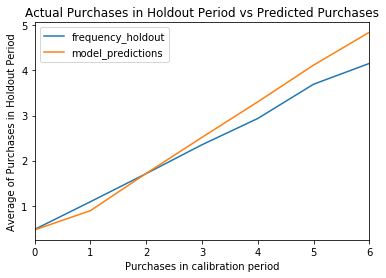

In [31]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Model summary
bgf.summary

In [92]:
## We can visualize one particular customer
# from lifetimes.plotting import plot_history_alive

# # id = 2244229397 
# id = 7004575757
# #days_since_birth = 200
# days_since_birth = round((pd.to_timedelta(pd.Timestamp('2020-01-01T00') 
#                   - pd.Timestamp((df_ml[df_ml['club_card_number'] == id]['receipt_issue_date'].min()))).days) / 7)
# sp_trans = df_ml.loc[df_ml['club_card_number'] == id]
# plot_history_alive(bgf, 
#                    days_since_birth, 
#                    sp_trans, 
#                    'receipt_issue_date',
#                    xlim=['2018-01-01T00','2020-01-01T00']);

ValueError: cannot convert float NaN to integer

## Model fit over all data to predict 2020

In [33]:
# Transform transaction data into customer-based data with three attributes
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(df_ml, 
                                             'sfid', 
                                             'receipt_issue_date', 
                                             observation_period_end='2020-01-01',
                                             datetime_format = '%Y-%m-%d',
                                             freq='W',
                                             monetary_value_col = 'monetary_value')
summary.sample(2)

,frequency,recency,T,monetary_value
sfid,,,,
0035800001deteVAAQ,2.0,43.0,89.0,41.195
0031i000001uYF8AAM,0.0,0.0,63.0,0.000


In [34]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
# I am using some penalizer due to low sample size, see lifetimes documentation.
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.338722,0.000933,0.336894,0.340550
alpha,13.160704,0.053887,13.055085,13.266324
a,0.319184,0.002815,0.313667,0.324701
b,1.166088,0.010891,1.144742,1.187435


In [35]:
# Add predicted purchases to summary dataframe
# Predicted purchases are calculated for a given time window t
t = 4
summary['pred_purch_coming_week=' + str(t)] = (bgf.conditional_expected_number_of_purchases_up_to_time
                                               (
                                                t, 
                                                summary['frequency'], 
                                                summary['recency'], 
                                                summary['T']
                                               )
                                              )

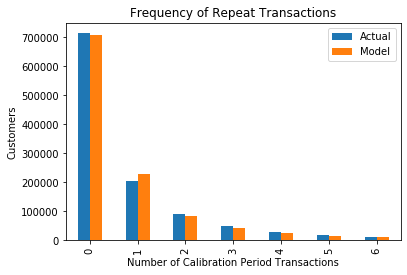

In [36]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [37]:
# Based on customer history, we can predict what an individuals future purchases might look like:
individual = summary.iloc[12386]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.01699379487165054

## CLV: Including transactional component

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel

In [30]:
returning_customers_summary = summary[summary['frequency']>0]
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value']>0]

In [31]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 146041 subjects, p: 2.57, q: 7.34, v: 72.77>


In [32]:
ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],
                                        returning_customers_summary['monetary_value'])

SFID
0031i000001rNF1AAM    44.444453
0031i000001rNFTAA2    22.291376
0031i000001rNFqAAM    26.594675
0031i000001rNFsAAM    25.847123
0031i000001rNFyAAM    34.599406
                        ...    
0035800001gxc6QAAQ    26.397166
0035800001gxc6SAAQ    22.611276
0035800001gxc6VAAQ    29.594729
0035800001gxc6YAAQ    27.814581
0035800001gxcANAAY    25.869441
Length: 146041, dtype: float64

In [33]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value']
    ).mean(),
    returning_customers_summary[returning_customers_summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 29.545295749978077, Average profit: 29.086106804148933


In [34]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(returning_customers_summary['frequency'], 
        returning_customers_summary['recency'], 
        returning_customers_summary['T'],
        returning_customers_summary['monetary_value'])

<lifetimes.BetaGeoFitter: fitted with 146041 subjects, a: 0.30, alpha: 34.78, b: 1.17, r: 2.64>

In [35]:
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=12, # months
    discount_rate=0.01,# monthly discount rate ~ 12.7% annually
    freq = 'W')

In [36]:
clv

SFID
0031i000001rNF1AAM    427.336419
0031i000001rNFTAA2     87.320614
0031i000001rNFqAAM    304.170638
0031i000001rNFsAAM     29.479645
0031i000001rNFyAAM     22.895223
                         ...    
0035800001gxc6QAAQ     10.528726
0035800001gxc6SAAQ     73.148015
0035800001gxc6VAAQ     81.321041
0035800001gxc6YAAQ     11.777538
0035800001gxcANAAY     27.161048
Name: clv, Length: 146041, dtype: float64

In [37]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

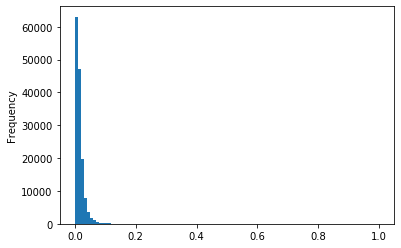

In [38]:
normalize(clv).plot(kind='hist', bins = 100)

## Comparison DeFacto

In [53]:
import os
import plotnine as p9

In [40]:
path = 'u:\\Projects\\datasets\\customer_history\\DeFacto_scores'
file = 'Orsay_Promo_salesforce_January_2020.csv' # PreSale January 2020
file = '20190913_Score_Winter_Celebration.csv'   # Winter Celebration December 2019
file = '20191025_Winter_Presale_Daten_Score.csv' # Winter PreSale  2019
os.chdir(path)
os.getcwd()

## Import data
files = os.listdir()
df_defacto = pd.read_csv(files[files.index(file)],sep=';', 
                          header = 0,
                          decimal=",")

In [69]:
df_defacto.shape[0] - df_defacto.SFID.unique().shape[0]

2997

In [48]:
df_defacto.columns = [c.lower() for c in df_defacto.columns]

In [41]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

In [49]:
df_orsay = summary.copy()
df_orsay = df_orsay.assign(norm_purchase = lambda d: normalize(d['pred_purch_coming_week=4']))
df_orsay.reset_index(level=0, inplace=True)
df_orsay

,sfid,frequency,recency,T,monetary_value,pred_purch_coming_week=4,norm_purchase
0,0031i000001rNElAAM,1.0,1.0,68.0,117.950000,0.017084,0.006287
1,0031i000001rNLxAAM,0.0,0.0,14.0,0.000000,0.048887,0.017991
2,0031i000001rNNiAAM,1.0,1.0,38.0,35.990000,0.040933,0.015064
3,0031i000001rNRDAA2,0.0,0.0,22.0,0.000000,0.037932,0.013959
4,0031i000001rNTnAAM,0.0,0.0,61.0,0.000000,0.018131,0.006672
...,...,...,...,...,...,...,...
1148559,0035800001gxdDIAAY,1.0,27.0,68.0,25.990000,0.038484,0.014162
1148560,0035800001gxdGhAAI,0.0,0.0,68.0,0.000000,0.016578,0.006101
1148561,0035800001gxdIrAAI,0.0,0.0,68.0,0.000000,0.016578,0.006101
1148562,0035800001gxdJgAAI,4.0,63.0,68.0,43.592500,0.192769,0.070941


In [50]:
merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')

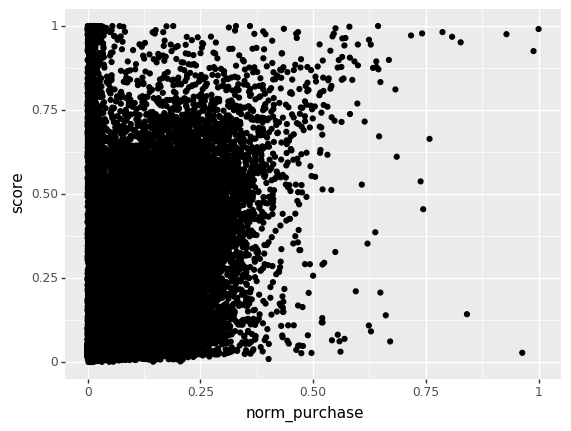

<ggplot: (-9223371961215037160)>

In [56]:
(p9.ggplot(mapping=p9.aes(x='norm_purchase', y='score'), data=merged_orsay_defacto_data)
+ p9.geom_point())

In [64]:
merged_orsay_defacto_data.corr()

,frequency,recency,T,monetary_value,pred_purch_coming_week=4,norm_purchase,Score
frequency,1.000000,0.695484,0.224029,0.421136,0.850366,0.850366,0.650439
recency,0.695484,1.000000,0.382875,0.459184,0.536075,0.536075,0.429065
T,0.224029,0.382875,1.000000,0.114563,-0.084582,-0.084582,-0.122340
monetary_value,0.421136,0.459184,0.114563,1.000000,0.365688,0.365688,0.412887
pred_purch_coming_week=4,0.850366,0.536075,-0.084582,0.365688,1.000000,1.000000,0.739959
norm_purchase,0.850366,0.536075,-0.084582,0.365688,1.000000,1.000000,0.739959
Score,0.650439,0.429065,-0.122340,0.412887,0.739959,0.739959,1.000000
